In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy
import plotnine as pn
import re
from IPython.display import Markdown as md
from IPython.display import display, Latex
import os
from datetime import datetime
from itables import show
from itables import options as opt
import sys

In [3]:
opt.buttons = ['copy', 'excel', 'pdf']

In [4]:
COLORS = [
    "#279989",
    "#EAAA00",
    "#F9423A",
    "#1D252D",
    "#D9D9D6",
    "#1C6E63",
    "#fb9a99",
    "#cab2d6",
    "#33a02c",
    "#355C7D",
    "#A8E6CE",
    "#CC527A"
]

In [4]:
# parameters, get replaced when notebook is compiled by papermill

# Parameters
in_notebook = (
    "/home/kyakimovich/repos/ctDNA_Pro_Pipeline/patient_reports/report_template.ipynb"
)
out_notebook = "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/reports/JGH_001/JGH_001_report.ipynb"
maf_files = [
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/sage_pipeline/99-final/JGH_001_C2.sage.processed.maf",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/sage_pipeline/99-final/JGH_001_DX.sage.processed.maf",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/sage_pipeline/99-final/JGH_001_R.sage.processed.maf",
]
samplesheet_path = "/projects/rmorin_scratch/prospective_rrDLBCL_trial_data/samplesheets/LSARP_samples_current.tsv"
patient_id = "JGH_001"
hs_metrics = [
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/bam_pipeline/Q2-hs_metrics/JGH_001_C2.hs_metrics.txt",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/bam_pipeline/Q2-hs_metrics/JGH_001_DX.hs_metrics.txt",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/bam_pipeline/Q2-hs_metrics/JGH_001_R.hs_metrics.txt",
]
targ_cov = [
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/bam_pipeline/Q2-hs_metrics/JGH_001_C2.target_coverage.txt",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/bam_pipeline/Q2-hs_metrics/JGH_001_DX.target_coverage.txt",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/bam_pipeline/Q2-hs_metrics/JGH_001_R.target_coverage.txt",
]
repo_path = "/home/kyakimovich/repos/ctDNA_Pro_Pipeline"
completion_files = [
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/completion/JGH_001_C2.completion.txt",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/completion/JGH_001_DX.completion.txt",
    "/projects/rmorin/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/completion/JGH_001_R.completion.txt",
]

lymphgen_output = ["/projects/rmorin_scratch/prospective_rrDLBCL_trial_data/pipeline_outputs/lymphgen-2.0/99-outputs/capture--hg38/JGH_001_R--None--no_normal/lymphgen_calls.no_cnvs.no_sv.no_A53.tsv"]

In [6]:
# import repo _version
sys.path.append(repo_path)
from _version import __version__ as pv
# import report version
from patient_reports._version_report import __version__ as rv

In [7]:
# regex anything after a / and before one of the file extensions
def re_sample(file_path):
    return re.search(r"/([^/]+)\.(?:processed.maf|sage.processed.maf|hs_metrics.txt|target_coverage.txt|completion.txt)", file_path).group(1)



In [8]:
# turn paths into dicts with sample name as the key 
maf_path_dict = {re_sample(path): path for path in maf_files}
hs_path_dict = {re_sample(path): path for path in hs_metrics}
sample_points = [sample.split("_")[-1] for sample in maf_path_dict.keys()]
cov_path_dict = {re_sample(path): path for path in targ_cov}
comp_path_dict = {re_sample(path): path for path in completion_files}

In [8]:
# get latest samplesheet
samplesheet_all = pd.read_csv(samplesheet_path, sep="\t")
samplesheet = samplesheet_all[samplesheet_all["patient_id"] == patient_id]
# remove any normal samples from samplesheet using timepoint
# samplesheet = samplesheet[~samplesheet["timepoint"].str.contains("normal")]



In [9]:
%%capture
# order the timepoints in samplesheet
time_order = ["normal","DX", "RCHOP1", "RCHOP2", 'RCHOP3', 'RCHOP4','RCHOP5', 'EOTRCHOP', 'SURVEILLANCE',"RELAPSE", 'RELAPSE1', 'RELAPSE2+']
# reorder timepoint column so DX commes before RCHOP1
samplesheet["timepoint"] = pd.Categorical(samplesheet["timepoint"], time_order).copy()
# change samplesheet date col to date type
samplesheet.loc[:, "date"] = pd.to_datetime(samplesheet.loc[:,"date(MM-DD-YYYY)"], format="%m/%d/%Y").dt.date

# reorder index based on timepoint
samplesheet = samplesheet.sort_values(["date","timepoint"]).reset_index(drop=True)

# remove , from HGE/mL_plasma column and turn it into a float 
samplesheet["HGE/mL_plasma"] = samplesheet["HGE/mL_plasma"].str.replace(",", "").astype(float)

# create combo timepoint and date column
samplesheet["timepoint_date"] = samplesheet["timepoint"].astype("str") + "\n" + samplesheet["date"].astype(str)

# order timepoint_date based on date
samplesheet["timepoint_date"] = pd.Categorical(samplesheet["timepoint_date"], samplesheet["timepoint_date"].unique()).copy()

In [11]:
ss_cols = ['patient_id', 'sample_id', 'timepoint', 
       'cfDNA_concentration_(ng/uL)',  'hybridization', 'run_id' ]

In [12]:
#| tbl-cap: "Patient Information"
#| label: tbl-patient_info

samplesheet[ss_cols].style.hide()


patient_id,sample_id,timepoint,cfDNA_concentration_(ng/uL),hybridization,run_id
JGH_001,JGH_001_GL,normal,nan,P_11,pro_pool12
JGH_001,JGH_001_DX,DX,0.888,P_11,pro_pool12
JGH_001,JGH_001_C2,RCHOP1,0.402,P_11,pro_pool12
JGH_001,JGH_001_R,RELAPSE1,6.26,P_20,pro_pool15


In [13]:

def parse_completion_times(comp_file_dict: dict) -> dict:
    comp_times = {}
    for sample, comp_file in comp_file_dict.items():
        with open(comp_file, "r") as f:
            comp_times[sample] = f.read().strip()
    return comp_times

comp_dict = parse_completion_times(comp_path_dict)

In [14]:
#| tbl-cap: "Turn around time"
#| label: tbl-tot

tot_df = samplesheet.copy()
tot_df = tot_df[~tot_df["timepoint"].str.contains("normal")]
# turn date column into datetime
tot_df.loc[:, "date_collected_stamp"] = pd.to_datetime(tot_df.loc[:,"date(MM-DD-YYYY)"], format="%m/%d/%Y")
# make version of column that is just the date, looks nicer
tot_df.loc[:, "date_collected"] = tot_df.loc[:, "date_collected_stamp"].dt.date
# get date when maf files were created
tot_df.loc[:, "pipeline_time"] = tot_df["sample_id"].map(comp_dict)
# turn date column into datetime
tot_df.loc[:, "pipeline_time_stamp"] = pd.to_datetime(tot_df.loc[:,"pipeline_time"], format="%m/%d/%Y").copy()

tot_df.loc[:, "pipeline_time"] = tot_df.loc[:, "pipeline_time_stamp"].dt.date

# create tat column
tot_df.loc[:, "TAT_diff"] = tot_df["pipeline_time_stamp"]- tot_df["date_collected_stamp"]
# convert TOT into a obj column for display purposes
tot_df.loc[:, "TAT (days)"] = tot_df["TAT_diff"].dt.days

# display the table
tot_df[['sample_id', 'date_collected', 'pipeline_time',"TAT (days)"]].style.hide()

sample_id,date_collected,pipeline_time,TAT (days)
JGH_001_DX,2024-02-14,2024-03-22,37
JGH_001_C2,2024-03-08,2024-03-22,14
JGH_001_R,2024-04-30,2024-05-14,14


# QC

## HS Metrics

In [15]:
def parse_hs_metrics(qc_dict: dict):
    # use pandas to parse the file but only read in the 7th and 8th line
    qc_dfs = []
    for sample in qc_dict:
        try:
            df = pd.read_csv(qc_dict[sample], sep="\t", skiprows=6, nrows=1)
            df['sample_id'] = sample
            qc_dfs.append(df)
        # exception for when file isnt found, just return none
        except FileNotFoundError:
            # add warning with purple text
            print(f"HS metrics not found for {sample}")
            return None

    return pd.concat(qc_dfs)

In [16]:
hs_cols = ['sample_id','timepoint', 'TOTAL_READS','FOLD_80_BASE_PENALTY','ZERO_CVG_TARGETS_PCT',
'MEAN_TARGET_COVERAGE', 'MEDIAN_TARGET_COVERAGE', 'MAX_TARGET_COVERAGE', 'MIN_TARGET_COVERAGE']

In [17]:
hs_df = parse_hs_metrics(hs_path_dict)

In [18]:
if hs_df is not None:
    hs_df = hs_df.merge(samplesheet[["sample_id","timepoint"]], how="left").copy()
    # add in "normal" for timepoint where is is missing
    hs_df["timepoint"] = hs_df["timepoint"].fillna("normal")
    # sort samplesheet by timepoint
    hs_df["timepoint"] = pd.Categorical(hs_df["timepoint"], time_order).copy()
    hs_df = hs_df.sort_values("timepoint").reset_index(drop=True)
    # sort sample_id by timepoint
    hs_df["sample_id"] = pd.Categorical(hs_df["sample_id"], hs_df["sample_id"].unique()).copy()

    cov_cols = ["sample_id" ,'PCT_TARGET_BASES_50X', 'PCT_TARGET_BASES_250X','PCT_TARGET_BASES_500X', 'PCT_TARGET_BASES_1000X']
    # change table so coverage percentage is a column
    hs_df_cov = hs_df[cov_cols].melt(id_vars="sample_id", value_vars=cov_cols, var_name="coverage", value_name="percentage")

    # order coverage column
    hs_df_cov["coverage"] = pd.Categorical(hs_df_cov["coverage"], cov_cols).copy()

    # turn percentage into actual percentage
    hs_df_cov["percentage"] = hs_df_cov["percentage"]*100


In [19]:
#| tbl-cap: "HS Metrics"
#| label: tbl-hs

if hs_df is not None:
    display(hs_df[hs_cols].style.hide())


sample_id,timepoint,TOTAL_READS,FOLD_80_BASE_PENALTY,ZERO_CVG_TARGETS_PCT,MEAN_TARGET_COVERAGE,MEDIAN_TARGET_COVERAGE,MAX_TARGET_COVERAGE,MIN_TARGET_COVERAGE
JGH_001_DX,DX,7189256,1.317005,0.003185,557.093201,574,1907,0
JGH_001_C2,RCHOP1,8581812,1.266880,0.003583,623.304815,654,1801,0
JGH_001_R,RELAPSE1,6058746,1.424191,0.003185,437.226493,431,1603,0


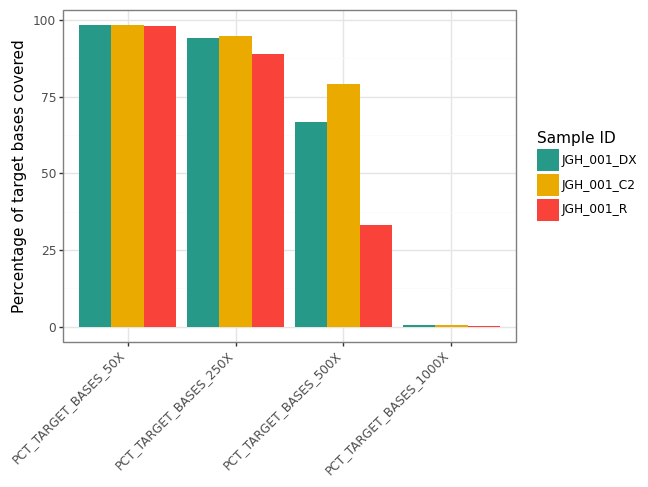

In [20]:
#| fig-cap: "Percentage of bases achieving different thresholds of coverage, as calculated by picard."
#| label: fig-hs_cov
if hs_df is not None:
        plot = (pn.ggplot(hs_df_cov, pn.aes(x="coverage", y="percentage", fill="sample_id")) +
                pn.geom_bar(stat="identity", position="dodge") +
                pn.theme_bw() +
                pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1)) +
                pn.scale_fill_manual(values=COLORS) +
                pn.labs(x="", y="Percentage of target bases covered", fill="Sample ID") 
        )

        display(plot.draw())

## Target Coverage

In [21]:
# parse coverage files

def parse_coverage(path_dict: dict) -> pd.DataFrame: 
    cov_dfs = []
    for sample in path_dict:
        df = pd.read_csv(path_dict[sample], sep="\t")
        df["sample_id"] = sample
        cov_dfs.append(df)
    return pd.concat(cov_dfs) 

In [22]:
all_cov = parse_coverage(cov_path_dict)
# merge with samplesheet to get timepoint
all_cov = all_cov.merge(samplesheet[["sample_id","timepoint"]], how="left").copy()
# sort df
all_cov = all_cov.sort_values("timepoint").reset_index(drop=True).copy()
# order sample id based on timepoint column
all_cov["sample_id"] = pd.Categorical(all_cov["sample_id"], all_cov["sample_id"].unique()).copy()

# add in "normal" for timepoint where is is missing
all_cov["timepoint"] = all_cov["timepoint"].fillna("normal")


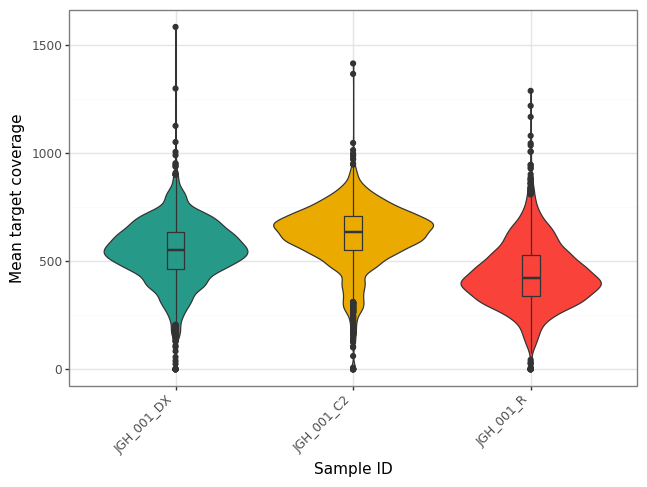

In [23]:
#| fig-cap: "Mean coverage of each capture target per sample."
#| label: fig-cov

# create a coverage boxplot by sample

plot = (pn.ggplot(all_cov, pn.aes(x="sample_id", y="mean_coverage", fill="sample_id")) +
        pn.geom_violin() +
        pn.geom_boxplot(width=0.1) +
        pn.theme_bw() +
        pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1)) +
        pn.scale_fill_manual(values=COLORS) +
        pn.labs(x="Sample ID", y="Mean target coverage", fill="Sample ID") +
        # hide legend
        pn.theme(legend_position="none")
       )

plot.draw()

## Targets with no coverage

In [24]:
cov_cols = ['sample_id','chrom', 'start', 'end', 'length', 'name', '%gc', 'mean_coverage','max_coverage','min_coverage','pct_0x',
       'read_count']

In [25]:
# print coverage table per sample

for sample in all_cov["sample_id"].unique():
    sample_cov = all_cov[all_cov["sample_id"] == sample].copy()
    display(md(f"## {sample}"))
    show(sample_cov.loc[sample_cov["pct_0x"] >= 0.5][cov_cols].style.hide())
    

## JGH_001_DX

sample_id,chrom,start,end,length,name,%gc,mean_coverage,max_coverage,min_coverage,pct_0x,read_count
JGH_001_DX,chr8,128748353,128749427,1075,MYC-TSS,0.388837,0.000000,0,0,1.000000,0
JGH_001_DX,chr1,120051733,120051779,47,NOTCH2,0.446809,0.000000,0,0,1.000000,0
JGH_001_DX,chr1,161670252,161670272,21,FCGR2B,0.619048,0.000000,0,0,1.000000,0
JGH_001_DX,chr1,161588422,161588442,21,FCGR2C,0.619048,0.000000,0,0,1.000000,0
JGH_001_DX,chr1,161581438,161581549,112,FCGR2C,0.544643,0.000000,0,0,1.000000,0
JGH_001_DX,chr1,161663242,161663353,112,FCGR2B,0.544643,0.366071,1,0,0.633929,1
JGH_001_DX,chrY,1536921,1537294,374,P2RY8,0.000000,0.000000,0,0,1.000000,0
JGH_001_DX,chrY,1468502,1468670,169,P2RY8,0.000000,0.000000,0,0,1.000000,0
JGH_001_DX,chrY,1465479,1466582,1104,P2RY8,0.000000,0.000000,0,0,1.000000,0


## JGH_001_C2

sample_id,chrom,start,end,length,name,%gc,mean_coverage,max_coverage,min_coverage,pct_0x,read_count
JGH_001_C2,chrY,1468502,1468670,169,P2RY8,0.000000,0.000000,0,0,1.000000,0
JGH_001_C2,chr8,128748353,128749427,1075,MYC-TSS,0.388837,0.000000,0,0,1.000000,0
JGH_001_C2,chr1,120051733,120051779,47,NOTCH2,0.446809,0.000000,0,0,1.000000,0
JGH_001_C2,chr1,161670252,161670272,21,FCGR2B,0.619048,0.000000,0,0,1.000000,0
JGH_001_C2,chr1,161663242,161663353,112,FCGR2B,0.544643,0.000000,0,0,1.000000,0
JGH_001_C2,chr1,161588422,161588442,21,FCGR2C,0.619048,0.000000,0,0,1.000000,0
JGH_001_C2,chr1,161581438,161581549,112,FCGR2C,0.544643,0.000000,0,0,1.000000,0
JGH_001_C2,chrY,1536921,1537294,374,P2RY8,0.000000,0.000000,0,0,1.000000,0
JGH_001_C2,chrY,1465479,1466582,1104,P2RY8,0.000000,0.000000,0,0,1.000000,0


## JGH_001_R

sample_id,chrom,start,end,length,name,%gc,mean_coverage,max_coverage,min_coverage,pct_0x,read_count
JGH_001_R,chrY,1465479,1466582,1104,P2RY8,0.000000,0.000000,0,0,1.000000,0
JGH_001_R,chrY,1468502,1468670,169,P2RY8,0.000000,0.000000,0,0,1.000000,0
JGH_001_R,chr1,161581438,161581549,112,FCGR2C,0.544643,0.000000,0,0,1.000000,0
JGH_001_R,chr1,161588422,161588442,21,FCGR2C,0.619048,0.000000,0,0,1.000000,0
JGH_001_R,chr1,161663242,161663353,112,FCGR2B,0.544643,0.000000,0,0,1.000000,0
JGH_001_R,chr1,161670252,161670272,21,FCGR2B,0.619048,0.000000,0,0,1.000000,0
JGH_001_R,chr1,120051733,120051779,47,NOTCH2,0.446809,0.000000,0,0,1.000000,0
JGH_001_R,chr8,128748353,128749427,1075,MYC-TSS,0.388837,0.103256,1,0,0.896744,2
JGH_001_R,chrY,1536921,1537294,374,P2RY8,0.000000,0.000000,0,0,1.000000,0


In [ ]:
# read in all the mutations

def parse_maf_files(maf_dict: dict):
    """Parse maf files
    If file has no lines, then add line with sample_id and timepoint
    as placeholder.
    """
    maf_dfs = []
    for sample in maf_dict:
        # read in 'Tumor_Sample_Barcode' as string
        df = pd.read_csv(maf_dict[sample], sep="\t", dtype={"Tumor_Sample_Barcode": str})
        if df.empty:
            df = pd.DataFrame({"Tumor_Sample_Barcode": [sample]})
        maf_dfs.append(df)

    return pd.concat(maf_dfs)

In [27]:
all_maf_calls = parse_maf_files(maf_path_dict)


In [28]:
# if no maf calls print empty warning
if len(all_maf_calls.columns) == 1:
    display(md("# No variant calls found for patient. Haulting report compilation"))
    sys.exit(0) # silently haults execution, no need to continue with no variants

In [29]:

all_maf_calls.rename(columns={'Tumor_Sample_Barcode': 'Sample_ID',
                               "Matched_Norm_Sample_Barcode": "Normal_ID",
                               }, inplace=True)

all_maf_calls['AF'] = all_maf_calls['t_alt_count'] / all_maf_calls['t_depth']
# create version wtih no chip
all_maf_calls_nochip = all_maf_calls.loc[(all_maf_calls["CHIP"]==False) | (all_maf_calls["CHIP"].isna())].copy()

# merge with samplesheet
all_maf_wmeta_calls = all_maf_calls.merge(samplesheet[["sample_id","timepoint","date", "timepoint_date"]], how="left", left_on="Sample_ID",right_on="sample_id").copy()
all_maf_wmeta_calls_nochip = all_maf_calls_nochip.merge(samplesheet[["sample_id","timepoint","date", "timepoint_date"]], how="right", left_on="Sample_ID",right_on="sample_id").copy()
# drop normal timepoint
all_maf_wmeta_calls_nochip = all_maf_wmeta_calls_nochip[~all_maf_wmeta_calls_nochip["timepoint"].str.contains("normal")].copy()

In [30]:
all_maf_wmeta_calls["variant_id"] = all_maf_wmeta_calls["Hugo_Symbol"] + ":" + all_maf_wmeta_calls["HGVSp"].astype(str) + ": " + all_maf_wmeta_calls["Chromosome"].astype(str)+":"+ all_maf_wmeta_calls["Start_Position"].astype(str) +"-" + all_maf_wmeta_calls["End_Position"].astype(str)
all_maf_wmeta_calls_nochip["variant_id"] = all_maf_wmeta_calls_nochip["Hugo_Symbol"] + ":" + all_maf_wmeta_calls_nochip["HGVSp"].astype(str) + ": " + all_maf_wmeta_calls_nochip["Chromosome"].astype(str)+":"+ all_maf_wmeta_calls_nochip["Start_Position"].astype(str) +"-" + all_maf_wmeta_calls_nochip["End_Position"].astype(str)

# ctDNA Quantification

In [31]:
def calc_hgeml(cfdna_conc: float, mean_AF: float)-> float:
    """Calculate hGE/mL of ctDNA.

    Args:
        cfdna_conc: ng/uL of cfDNA extracted
        mean_AF: mean AF of variants called in ctDNA.

    Returns:
        log hGE/mL
    """
    hge_cfdna = (10**6 * cfdna_conc) / 3.3
    hge_ctdna = (hge_cfdna * mean_AF)
    return numpy.log10(hge_ctdna)

# old calculation, if you need to start from ng/uL extraction
# mean_af["log hGE/mL"] = mean_af.apply(lambda row: calc_hgeml(row["cfDNA_concentration_(ng/uL)"], row["AF"]), axis=1)

# subtract the log hgml frome the previous timepoint for fold change
def calc_fold_change(df: pd.DataFrame)-> pd.DataFrame:
    """Calculate fold change in ctDNA concentration between timepoints.

    Args:
        df: DataFrame with log hGE/mL of ctDNA

    Returns:
        DataFrame with fold change column.
    """
    df["log hGE/mL"] = df["log hGE/mL"].astype(float)
    df["fold_change"] = df["log hGE/mL"] - df["log hGE/mL"].shift(1)
    # round the value to 2 decimal places
    df["fold_change"] = df["fold_change"].round(2)
    return df.copy()


In [32]:

# get table of mean AF per sample
mean_af = all_maf_wmeta_calls_nochip.groupby(["sample_id", "timepoint","timepoint_date"], observed=True)["AF"].mean().reset_index()
mean_af = mean_af.merge(samplesheet[["sample_id","cfDNA_concentration_(ng/uL)","plasma_volume_mL","HGE/mL_plasma","patient_id","date","timepoint"]], how="left").copy()

# replace a 0 with NA so it isnt plotted
mean_af.replace(0, numpy.nan, inplace=True)

# rename AF to Mean AF
mean_af.rename(columns={"AF": "Mean AF"}, inplace=True)

# turn "cfDNA_concentration_(ng/uL)" to float
# mean_af["HGE/mL_plasma"] = mean_af["HGE/mL_plasma"].astype(float)
mean_af["log hGE/mL"] = numpy.log10(mean_af["HGE/mL_plasma"] * mean_af["Mean AF"])

mean_af.sort_values("timepoint", inplace=True)

# if log value is na replace it with a 0
mean_af["log hGE/mL"].replace(numpy.nan, 0, inplace=True)

# calc fold difference between the current and proceeding timepoint
#mean_af["fold_change"] = mean_af.groupby("patient_id")["log hGE/mL"].transform(lambda x: round(x - x.iloc[0],2))
mean_af = calc_fold_change(mean_af)

In [33]:
#| tbl-cap: "ctDNA concentrations of samples. Fold change is calculated from previous time point. Final value is log hGE/mL and is calculated by log((cfDNA (pg/mL) * mean AF)/ 3.3). TL = too low, UD = undetermined."
#| label: tbl-ctdna
# hide index and round values in plasma volume to 2 decimal places


mean_af_cols = ["sample_id", "timepoint","date", "Mean AF","cfDNA_concentration_(ng/uL)","plasma_volume_mL","HGE/mL_plasma", "log hGE/mL", "fold_change"]

conc_table = (mean_af[mean_af_cols]
.sort_values("date")
.rename(columns={"cfDNA_concentration_(ng/uL)": "cfDNA (ng/uL)", "plasma_volume_mL": "plasma volume (mL)", "HGE/mL_plasma":"HGE/mL plasma","fold_change": "Fold Change"})
)
# round all values to 2 decimal places
conc_table = conc_table.round(3)
# replace all nan with "UD"
conc_table["Mean AF"] = conc_table["Mean AF"].astype("str").replace("nan", "UD")
conc_table["Fold Change"] = conc_table["Fold Change"].astype("str").replace("nan", "--")

# if cfdna column is float, sometimes it is a string "TL"
if conc_table["cfDNA (ng/uL)"].dtype == "float64":
    display(conc_table.style.hide().format({"plasma volume (mL)": "{:.2f}", "cfDNA (ng/uL)": "{:.3f}","HGE/mL plasma":"{:.2f}","log hGE/mL": "{:.2f}"}))
else:
    display(conc_table.style.hide().format({"plasma volume (mL)": "{:.2f}","HGE/mL plasma":"{:.2f}","log hGE/mL": "{:.2f}"}))


sample_id,timepoint,date,Mean AF,cfDNA (ng/uL),plasma volume (mL),HGE/mL plasma,log hGE/mL,Fold Change
JGH_001_DX,DX,2024-02-14,0.083,0.888,1.40,5766.23,2.68,--
JGH_001_C2,RCHOP1,2024-03-08,0.048,0.402,1.00,3654.55,2.24,-0.44
JGH_001_R,RELAPSE1,2024-04-30,0.298,6.26,6.30,18066.38,3.73,1.49


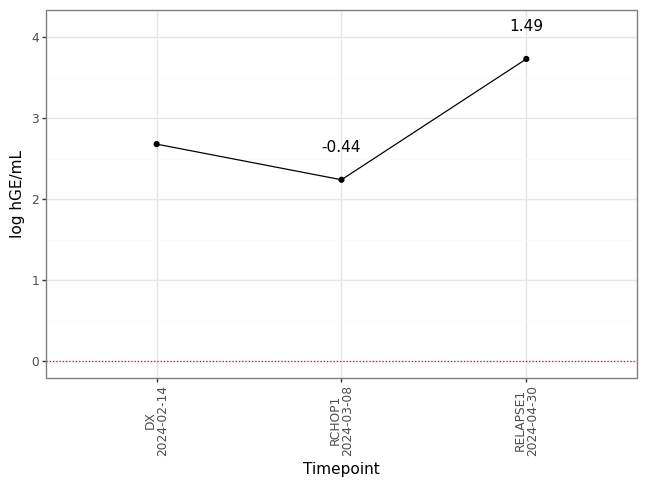

In [34]:
#| fig-cap: "ctDNA concentrations across treatment. Fold changes are printed graph and is calculated from previous timepoint."
#| label: fig-ctdna

# calculate fold difference and annotate graph with it
mean_af["fold_diff"] = mean_af["log hGE/mL"] - mean_af["log hGE/mL"].shift(1)

plot = (pn.ggplot(mean_af, pn.aes(x="timepoint_date", y="log hGE/mL", group="patient_id")) +
        pn.geom_point() +
        pn.geom_line() +
        pn.theme_bw() +
        pn.theme(axis_text_x=pn.element_text(rotation=90)) +
        pn.scale_fill_manual(values=COLORS) +
        pn.labs(x="Timepoint", y="log hGE/mL", fill="Sample ID") +
        pn.geom_text(pn.aes(label="fold_change"), nudge_y=0.4) +
        # add red dotted line at 0
        pn.geom_hline(yintercept=0, linetype="dotted", color="red")

       )

plot.draw()

# Variants


In [35]:
# columns of interest in maf
maf_cols = ['Sample_ID' ,'Hugo_Symbol', 'Chromosome','Start_Position', 'End_Position','Reference_Allele','Tumor_Seq_Allele2', 'AF', 'HGVSp', 'Variant_Classification','dbSNP_RS','Match_Norm_Seq_Allele1',
't_depth','t_ref_count','t_alt_count','n_depth','n_ref_count','n_alt_count',"LPS", "variant_source",
"origin_samples", "UMI_mean","UMI_max", "STR"]

## Variants over time

In [36]:
def complete_var_obs(indf: pd.DataFrame) -> pd.DataFrame:
    """Create a new line for a timepoint if a given
    variant was observed there. Therefore vars from
    every timepoint should have a line for every
    timepoint. If not observed the AF will be set
    to 0.
    
    
    """
    # get all unique combos of variant_id by timepoint and sample id
    uvars = indf[["variant_id"]].drop_duplicates()
    utime = indf[["sample_id","timepoint","date","timepoint_date"]].drop_duplicates()
    # create a dataframe with all possible combinations of variant_id and timepoint
    exp_combos = pd.merge(utime, uvars, how="cross")

    # merge the two dataframes
    outdf = indf.merge(exp_combos, how="right", on=["sample_id", "variant_id", "timepoint","date","timepoint_date"]).copy()
    # if vaf is na then set it to 0
    outdf["AF"] = outdf["AF"].fillna(0)
    return outdf

In [37]:
complete_maf = complete_var_obs(all_maf_wmeta_calls_nochip)

In [38]:
# complete_maf.loc[complete_maf["variant_id"]== "PRKCB:c.422A>T"][["sample_id", "timepoint", "AF", "variant_id",'Center']]

In [53]:
# pick VAF scale for graph
if complete_maf["AF"].max() < 0.05:
    vaf_scale = numpy.arange(-0.1, 0.06, 0.005)
else:
    vaf_scale = numpy.arange(-0.1, 1.1, 0.05)

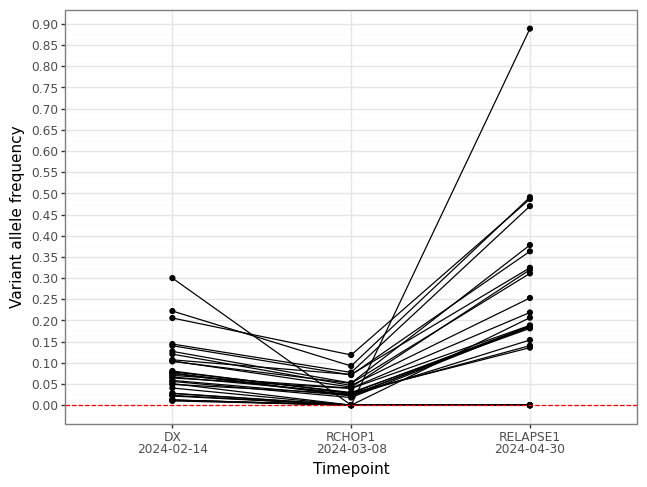

In [55]:
#| fig-cap: "Variant allele frequency over time points. The red dotted line indicates a VAF of zero. Variants were obtained from the SAGE output maf files."
#| label: fig-af

# if there are more than 100 variants skip plotting
if complete_maf["variant_id"].nunique() > 100:
        display(md("More than 100 variants found, skipping plot"))
else:
        plot = (pn.ggplot(complete_maf, pn.aes(x="timepoint_date", y = "AF", group = "variant_id" )) +
                pn.geom_point() +
                pn.geom_line() +
                pn.theme_bw() +
                pn.scale_fill_manual(values=COLORS) +
                pn.labs(x="Timepoint", y="Variant allele frequency", fill="Timepoint") +
                pn.scale_y_continuous(breaks=vaf_scale) +
                pn.geom_hline(yintercept=0, linetype="dashed", color="red")
        )

        display(plot.draw())

In [40]:
# find midpoint of AF column
midvalue = complete_maf["AF"].max() / 2


In [41]:
# sort by variant
complete_maf = complete_maf.sort_values("variant_id")

In [42]:
# sort values so ordered alphabetically on graph
# sort variant_id alphabetically, and exclude na values
heat_vars = complete_maf.loc[~complete_maf["variant_id"].isna()]

heat_vars = heat_vars.sort_values("variant_id", ascending=False).copy()
# order variant id
heat_vars["variant_id"] = pd.Categorical(heat_vars["variant_id"], heat_vars["variant_id"].unique()).copy()
# make sure AF column is a float 
# heat_vars["AF"] = heat_vars["AF"].astype(float)
# turn 0 values to NA
heat_vars["AF"] = heat_vars["AF"].replace(0, numpy.nan)

In [43]:
# get number of unique variant IDs
n_vars = len(heat_vars["variant_id"].unique())
heat_height = max(round(n_vars/5), 5)


In [44]:
%%capture
# plot variants across timepoints as heatmap

plot = (pn.ggplot(heat_vars, pn.aes(x="timepoint_date", y="variant_id", fill="AF")) +
        pn.geom_tile() +
        pn.coord_equal(ratio=0.7) +
        pn.theme_bw() +
        pn.scale_fill_gradient(low="white", high="black") +
        pn.theme(axis_text_x=pn.element_text(rotation=90, size=8)) +
        pn.labs(x="Timepoint", y="Variant ID", fill="Variant allele\nfrequency") +
        pn.theme(figure_size = (8,heat_height)) +

        pn.scale_fill_gradient2(low="#91bfdb", mid="#ffffbf", high="#fc8d59", midpoint=midvalue, na_value="white")
       )



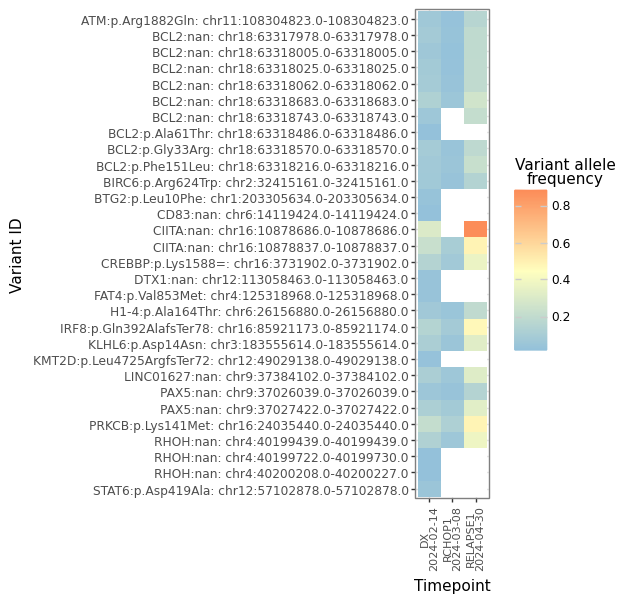

In [45]:
#| fig-cap: "Heatmap showing variant allele frequencies for all variants across treatment time points. If a grid tile is empty than that variant was not detected at that respective time point. Variants were obtained from the maf output files."
#| label: fig-af_heatmap

# only draw plot if there are less than 100 variants
if heat_vars["variant_id"].nunique() < 100:
    display(plot.draw())
else:
    display(md("More than 100 variants found, skipping plot"))

## Variants Tables

In [46]:
#| tbl-cap: "Variants Tables"
#| label: tbl-vars

all_maf_wmeta_calls_nochip = all_maf_wmeta_calls_nochip.sort_values("timepoint").reset_index(drop=True).copy()

for sample in all_maf_wmeta_calls_nochip["Sample_ID"].unique():
    sample_maf = all_maf_wmeta_calls_nochip[all_maf_wmeta_calls_nochip["Sample_ID"] == sample]
    display(md(f"## Sample: {sample}"))
    # display table and replace all _ in columns names with \n
    show(sample_maf[maf_cols], buttons= ['copy', 'excel', 'pdf'])
    

## Sample: JGH_001_DX

## Sample: JGH_001_C2

## Sample: JGH_001_R

# Potential CHIP mutations

Here are any mutations that had a suspicious amount of support in the normal, so was marked as a CHIP mutation and excluded from ctDNA calculations

In [47]:
show(all_maf_wmeta_calls
.loc[all_maf_wmeta_calls["CHIP"] == True][maf_cols], buttons= ['copy', 'excel', 'pdf'])

# Lymphgen

Lymphgen does not work as well without structural variant information, so we expect most samples not to get assigned a subtype

In [14]:
def parse_lg_status(lg_file: str) -> pd.DataFrame:
    all_df = []
    empty = []
    for file in lg_file:
        df = pd.read_csv(file, sep="\t")
        all_df.append(df)
    
    return pd.concat(all_df)

lg_df = parse_lg_status(lymphgen_output)

In [15]:
lg_df.rename(columns={"Sample.Name": "sample_id"}, inplace=True)
# print lg status table

lg_df_cols = ['sample_id', 'timepoint',"Subtype.Prediction"]
lg_df = lg_df.merge(samplesheet[["sample_id","timepoint","date", "timepoint_date"]], how="outer").copy()
lg_df = lg_df.sort_values("timepoint").reset_index(drop=True).copy()
# fill na with None
lg_df["Subtype.Prediction"] = lg_df["Subtype.Prediction"].fillna("None")

In [16]:
#| tbl-cap: "LymphGen Status"
#| label: tbl-lg

display(lg_df[lg_df_cols].style.hide())

sample_id,timepoint,Subtype.Prediction
JGH_001_GL,normal,None
JGH_001_DX,DX,None
JGH_001_C2,RCHOP1,None
JGH_001_R,RELAPSE1,EZB


In [48]:
# print version info
# add long line above and below version info
display(md("___"))
print('\033[95m' + f"Pipeline version: {pv}" )
print(f"Report version: {rv}")
display(md("___"))

___

Pipeline version: 2.1.0
Report version: 1.1.1


___